# Hochauflösende g-Spektrometrie mit einem Germanium-Detektor: Auswertung der Energiespektren bekannter Nuklide
---------------------------

## Radium 226, Radium Folgeprodukte  

$$
\begin{align}
    ^{226}_{80}\text{Ra} &\longrightarrow ^{222}_{86}\text{Rn} + \alpha (+ \gamma_{186 keV}) \\
    ^{222}_{86}\text{Rn} &\longrightarrow ^{218}_{84}\text{Po} + \alpha \\
    ^{218}_{84}\text{Po} &\longrightarrow ^{214}_{82}\text{Pb} + \alpha \\
    ^{214}_{82}\text{Pb} &\longrightarrow ^{214}_{83}\text{Bi} + \beta^- (+\gamma_{352, 295, 242, 53 keV} \\
    ^{214}_{83}\text{Bi} &\longrightarrow ^{214}_{84}\text{Po} + \beta^- (+\gamma_{609 keV} \\
    ...
\end{align}
$$
[Quelle: www.ld-didactic.de](https://www.ld-didactic.de/software/524221de/Content/Appendix/Ra226Series.htm)

Weitere gute Links:
* [Umfassende Bibliothek zu kernphysikalischen Kenndaten vieler (aller?) Nuklide](http://www.lnhb.fr/nuclear-data/nuclear-data-table/)
* [Lehrmaterial des BMU zu allerhand kernphysikalischer Messungen](https://www.bmu.de/themen/atomenergie-strahlenschutz/strahlenschutz/ionisierende-strahlung/ueberwachung-der-radioaktivitaet-in-der-umwelt/messanleitungen/messanleitungen-allgemeine-kapitel)

# Aufbau
-------------------------

<img src="./footage/germanium_detector.jpg" alt="Drawing" style="width: 500px;"/>  
<img src="./footage/mca_preamp_shaper.jpg" alt="Drawing" style="width: 300px;"/>  

Links: Messkammer mit Germaniumdetektor. Rechts: Multi-Channel-Analyzer mit Vorverstärker.

# Auswertung
------------------------

## Importe

>**Read the docs**  
>[https://lmfit.github.io/lmfit-py/](https://lmfit.github.io/lmfit-py/)  
>[https://www.scipy.org/docs.html](https://www.scipy.org/docs.html)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%config InlineBackend.figure_format = "svg" # crisper plots
import numpy as np
import pandas as pd
import lmfit as lm
from scipy.signal import find_peaks, peak_prominences

In [2]:
# Opening the data iterating over all the files found int eh cell above
sample_files = [
    "./messdaten/Ra-226-Spektren_V13/Ra-226_500ns_grosseTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_1us_grosseTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_2us_grosseTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_4us_grosseTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_2us_mittlereTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_4us_mittlereTotzeit.RPT",
    "./messdaten/Ra-226-Spektren_V13/Ra-226_4us_geringeTotzeit.RPT"]
spl_lst = []
for file in sample_files:
    with open(file, newline='', encoding='utf-8') as path:
        frame = pd.read_csv(path, delimiter=';')
        frame.columns = [col.strip() for col in frame] # stupid whitespaces t(-_-t)
        spl_lst.append(frame)
        del frame

g500ns = spl_lst[0]
g1us = spl_lst[1]
g2us = spl_lst[2]
g4us = spl_lst[3]
m2us = spl_lst[4]
m4us = spl_lst[5]
l4us = spl_lst[6]

## Plots

### Übersicht aller Messungen

In [3]:
# Nightowl mode
plt.style.use("default")
plt.style.use("dark_background")
cm = 1/2.54 # inch to cm, metric like brrr
size = 60

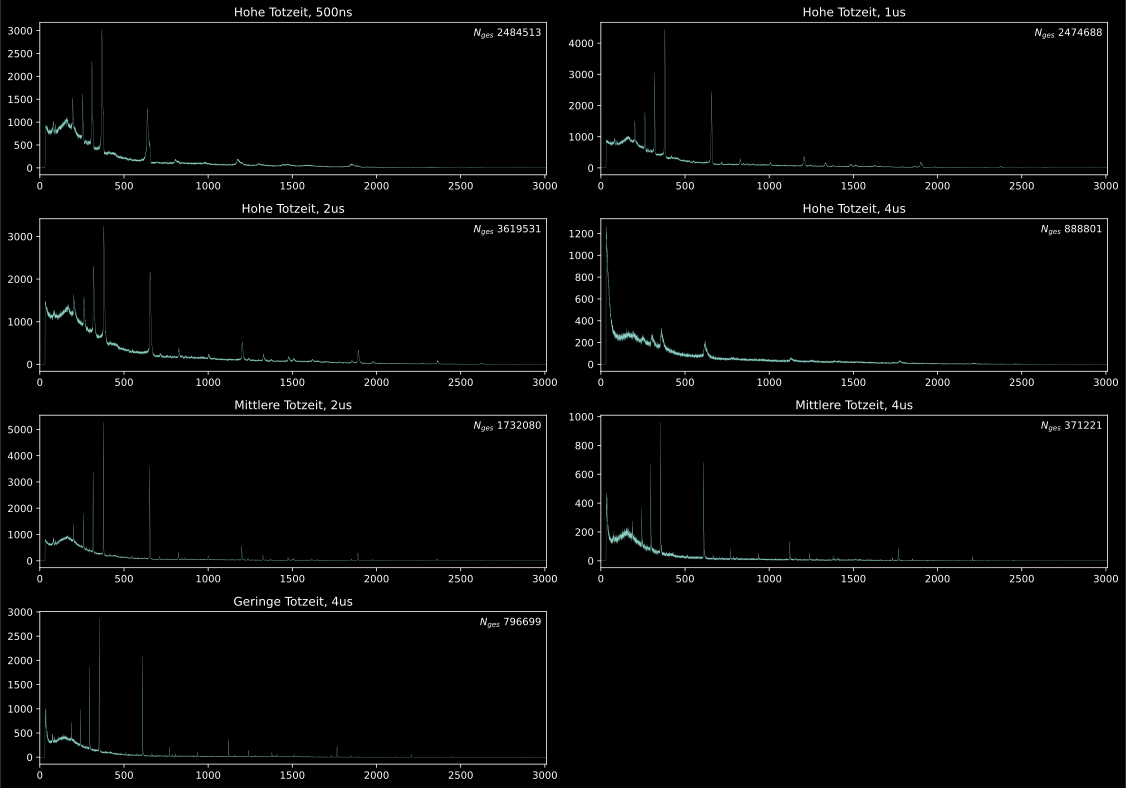

In [4]:
titles = ["Hohe Totzeit, 500ns", "Hohe Totzeit, 1us", "Hohe Totzeit, 2us","Hohe Totzeit, 4us","Mittlere Totzeit, 2us","Mittlere Totzeit, 4us","Geringe Totzeit, 4us"]
fig, ax = plt.subplots(4,2,figsize=(40*cm, 50*(9/16)*cm))
row, col, k = 4, 2, 0
for i in range(row):
	for j in range(col):
		if k == 7:
			ax[-1,-1].axis('off')
			break
		ax[i,j].plot(spl_lst[k]["Energie(keV)"], spl_lst[k]["Impulse"], linewidth=.2)
		ax[i,j].text(0.99, 0.96, "$N_{{ges}}$ {}".format(sum(spl_lst[k]["Impulse"])), transform=ax[i,j].transAxes, horizontalalignment='right', verticalalignment='top')
		ax[i,j].set_title(titles[k])
		ax[i,j].set_xlim(0, spl_lst[k]["Energie(keV)"].max())
		k += 1
plt.tight_layout()

### Funktion zur Kalibrierung

Funktion zur Energiekalibrierung nach dem [Bundesministerium für Umwelt, Naturschutz und nukleare Sicherheit](https://www.bmu.de/fileadmin/Daten_BMU/Download_PDF/Strahlenschutz/strlsch_messungen_gamma_grund_bf.pdf).

$$
E_j(K_j) = \sum_{i=0}e_i \cdot K_j^i
$$

Mit den Kalibrierkoeffizienten $e_i$ und den Soll-Energien $E_j$ an den Kanälen $K_j$. Für eine Kalibrierung an $n$ Peaks lassen sich die Kalibrierkoeffizienten $e_1$ bis $e_n$ finden durch lösen des linearen Gleichungssystems der Gestalt

$$
\begin{bmatrix}
e_1K_1^1 & e_2K_1^2 & \dots & e_nK_1^n \\
e_1K_2^1 & e_2K_2^2 & \dots & e_nK_2^n \\
\dots & \dots & \dots & \dots \\
e_nK_n^1 & e_2K_n^2 & \dots & e_nK_n^n \\
\end{bmatrix}
=
\begin{bmatrix}
E_1 \\ E_2 \\ \dots \\ E_n
\end{bmatrix}
$$
>Disclaimer: leider funktioniert untere Funktion nicht für Kalibrierungen auf mehr als drei Peaks. Warum ist zwar noch ungeklärt, eine Kalibrierung auf drei Punkte erscheint hier aber als ausreichend genau.

In [5]:
def channels_calib(channels, energies, u_arr, verbose=False):
	if len(channels) != len(energies):
		raise Exception("Ungleiche Anzahl Kanäle und Energien!")
	B = list(energies)
	A = [[channel**(j+1) for j in range(len(channels))] for channel in channels]
	coeffs = np.linalg.solve(A,B)
	if verbose == True:
		print("Koeffizientenmatrix: ",A,"\nOrdinatenmatrix: ",B)
		print("Kalibrierkoeffizienten: ",coeffs)

	def channel_calib(u_chan):
		c_chan = 0
		for i, coeff in enumerate(coeffs):
			c_chan += coeff * u_chan**(i+1)
		return c_chan
	c_arr = [channel_calib(u_chan) for u_chan in u_arr]
	return c_arr

# channels_calib(2049, 3548, 352, 609, m2us["Kanal"])

### Kalibrierung an l4us

In [6]:
energies = [53,186,242,295,352,609] # Energies to calibrate the lines to

Kanalnummern der peaks:  [1606 1915 3316]


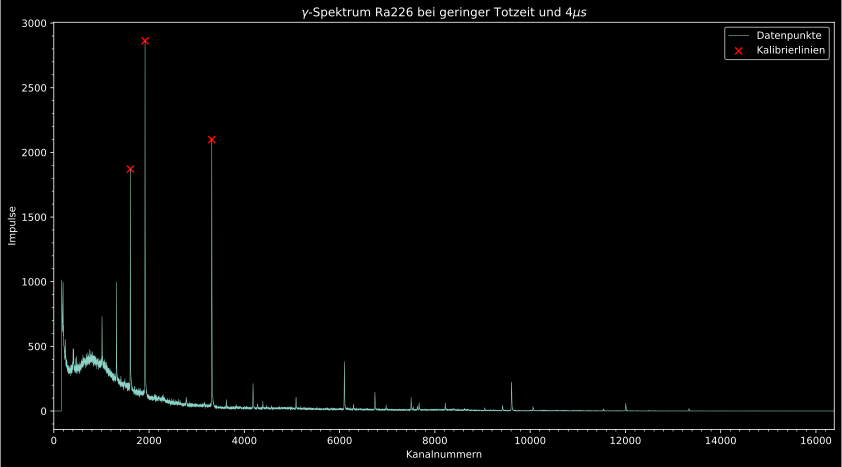

In [7]:
xarr = l4us["Kanal"]
yarr = l4us["Impulse"]

fig, ax = plt.subplots(figsize=(30*cm, 30*(9/16)*cm))
peaks, _ = find_peaks(yarr, prominence=(900, None), wlen=20) # adjust prominence/wlen
print("Kanalnummern der peaks: ", peaks)
l4us_channels = xarr.iloc[peaks]
ax.scatter(xarr.iloc[peaks], yarr.iloc[peaks], marker='x', s=50, color='r', label="Kalibrierlinien")
ax.plot(xarr, yarr, '-', linewidth=.5, label="Datenpunkte")
ax.set_title("$\gamma$-Spektrum Ra226 bei geringer Totzeit und 4$\\mu s$")
ax.set_xlabel("Kanalnummern")
ax.set_ylabel("Impulse")
ax.set_xlim(0, max(xarr))
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.legend()
plt.tight_layout()

In [8]:
Eb = [E**2 / (511 + 2*E) for E in energies]
print(Eb)
Ec = [E / (1 + 2*E/511) for E in energies]
print(Ec)

[4.552674230145867, 39.18006795016988, 58.858291457286434, 79.04178019981835, 101.97860082304527, 214.50607287449392]
[43.89465153970827, 107.63986409966026, 124.28341708542713, 136.9164396003633, 148.04279835390946, 179.98785425101212]


Koeffizientenmatrix:  [[1607, 2582449, 4149995543], [1916, 3671056, 7033743296], [3317, 11002489, 36495256013]] 
Ordinatenmatrix:  [295, 352, 609]
Kalibrierkoeffizienten:  [ 1.81831993e-01  1.59935575e-06 -3.21510724e-10]


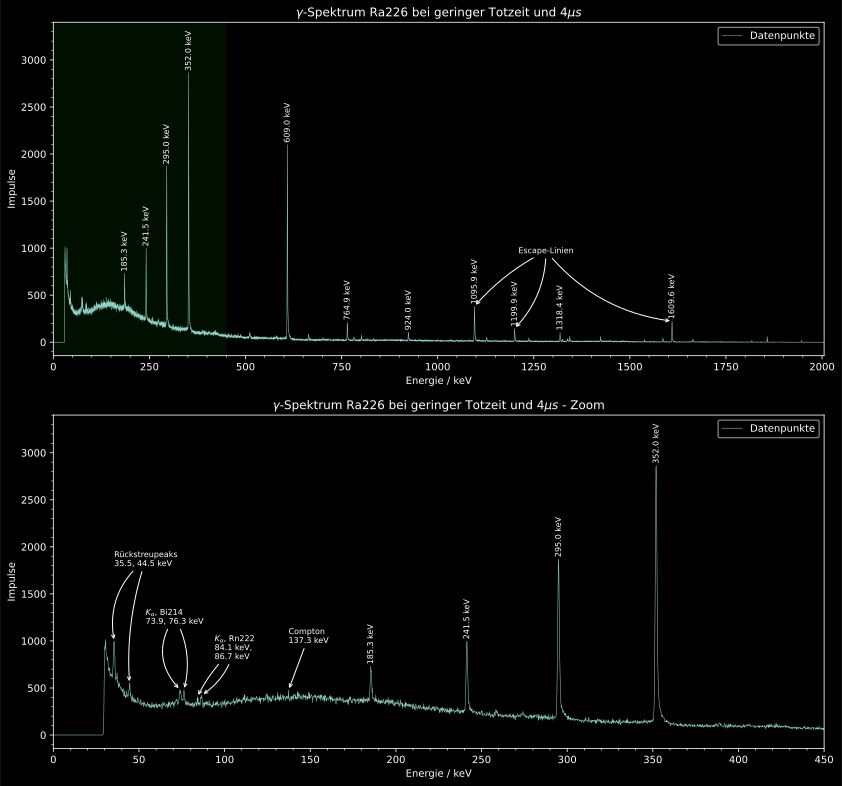

In [9]:
xarr = channels_calib(l4us_channels, energies[3:], l4us["Kanal"], verbose=True)
yarr = l4us["Impulse"].tolist()

fig, ax = plt.subplots(2, 1, figsize=(30*cm, 50*(9/16)*cm))
peaks, _ = find_peaks(yarr[:3500], prominence=(100, None), wlen=50) # adjust prominence/wlen
xpeaks, ypeaks = [xarr[peak] for peak in peaks], [yarr[peak] for peak in peaks]
peaks, _ = find_peaks(yarr[3501:], prominence=(90, None), wlen=150)
peaks = [peak+3501 for peak in peaks]
for peak in peaks:
	xpeaks.append(xarr[peak])
	ypeaks.append(yarr[peak])
# ax[0].scatter(xpeaks, ypeaks, marker='x', s=50, color='r', label="Kalibrierlinien") # for debugging purposes
for i, axis in enumerate(ax):
	axis.plot(xarr, yarr, '-', linewidth=.5, label="Datenpunkte")
	axis.set_xlabel("Energie / keV")
	axis.set_ylabel("Impulse")
	axis.set_xlim(0, max(xarr)-i*(max(xarr)-450))
	axis.set_ylim(top=3400)
	axis.yaxis.set_minor_locator(MultipleLocator(100))
	axis.legend()

	for xpeak, ypeak in zip(xpeaks[8:], ypeaks[8:]):
		axis.annotate("{} keV".format(round(xpeak, 1)), (xpeak, ypeak), (xpeak, ypeak+20), verticalalignment='bottom', horizontalalignment='center', rotation=90, fontsize=8)
ax[0].fill_between((0,450/max(xarr)), 0, 1, transform=ax[0].transAxes, color='#000f00')
# Compton
ax[1].annotate("Compton\n{} keV".format(round(xpeaks[7], 1)), (xpeaks[7], ypeaks[7]), (xpeaks[7], ypeaks[7]+500), horizontalalignment='left', fontsize=8, arrowprops={'arrowstyle': '->'})
# Back-Scatter
ax[1].annotate("Rückstreupeaks\n{0}, {1} keV".format(round(xpeaks[1], 1), round(xpeaks[2], 1)), (xpeaks[1], ypeaks[1]), (xpeaks[1], ypeaks[1]+800), horizontalalignment='left', fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0.3'})
ax[1].annotate("Rückstreupeaks\n{} keV".format(round(xpeaks[2], 1)), (xpeaks[2], ypeaks[2]), (xpeaks[1], ypeaks[1]+800), horizontalalignment='left', alpha=0.0, fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0.1'})
# X-Ray
ax[1].annotate("$K_{{\\alpha}}$, Bi214\n{0}, {1} keV".format(round(xpeaks[3], 1), round(xpeaks[4], 1)), (xpeaks[3], ypeaks[3]), (xpeaks[3]-20, ypeaks[3]+700), horizontalalignment='left', fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0.4'})
ax[1].annotate("$K_{{\\alpha}}$, Bi214\n{0}, {1} keV".format(round(xpeaks[3], 1), round(xpeaks[4], 1)), (xpeaks[4], ypeaks[4]), (xpeaks[3]-20, ypeaks[3]+700), horizontalalignment='left', alpha=0.0, fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=-0.2'})
ax[1].annotate("$K_{{\\alpha}}$, Rn222\n{0} keV,\n{1} keV".format(round(xpeaks[5], 1), round(xpeaks[6], 1)), (xpeaks[5], ypeaks[5]), (xpeaks[5]+10, ypeaks[5]+400), horizontalalignment='left', fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0.1'})
ax[1].annotate("$K_{{\\alpha}}$, Rn222\n{0} keV,\n{1} keV".format(round(xpeaks[5], 1), round(xpeaks[6], 1)), (xpeaks[6], ypeaks[6]), (xpeaks[5]+10, ypeaks[5]+400), horizontalalignment='left', alpha=0.0, fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=-0.2'})
# Escape
ax[0].annotate("Escape-Linien", (xpeaks[15], ypeaks[15]), (xpeaks[16]+10, ypeaks[16]+800), horizontalalignment='left', fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0.1'})
ax[0].annotate("Escape-Linien", (xpeaks[16], ypeaks[16]), (xpeaks[16]+10, ypeaks[16]+800), horizontalalignment='left', alpha=0.0, fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=-0.2'})
ax[0].annotate("Escape-Linien", (xpeaks[18], ypeaks[18]), (xpeaks[16]+10, ypeaks[16]+800), horizontalalignment='left', alpha=0.0, fontsize=8, arrowprops={'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0.2'})

ax[0].xaxis.set_minor_locator(MultipleLocator(50))
ax[1].xaxis.set_minor_locator(MultipleLocator(10))
ax[0].set_title("$\gamma$-Spektrum Ra226 bei geringer Totzeit und 4$\\mu s$")
ax[1].set_title("$\gamma$-Spektrum Ra226 bei geringer Totzeit und 4$\\mu s$ - Zoom")
plt.tight_layout()

### Kalibrierung an m2us

In [10]:
energies = [53,186,242,295,352,609] # Energies to calibrate the lines to

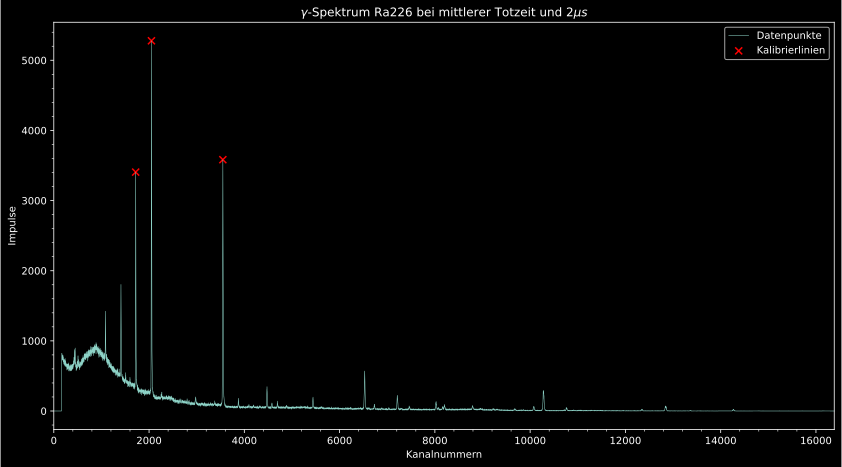

In [11]:
xarr = m2us["Kanal"]
yarr = m2us["Impulse"]

fig, ax = plt.subplots(figsize=(30*cm, 30*(9/16)*cm))
peaks, _ = find_peaks(yarr, height=2000, distance=30) # adjust height to filter out peaks
m2us_channels = xarr.iloc[peaks]
ax.scatter(xarr.iloc[peaks], yarr.iloc[peaks], marker='x', s=50, color='r', label="Kalibrierlinien")
ax.plot(xarr, yarr, '-', linewidth=.5, label="Datenpunkte")
ax.set_title("$\gamma$-Spektrum Ra226 bei mittlerer Totzeit und 2$\\mu s$")
ax.set_xlabel("Kanalnummern")
ax.set_ylabel("Impulse")
ax.set_xlim(0, max(xarr))
ax.xaxis.set_minor_locator(MultipleLocator(400))
ax.yaxis.set_minor_locator(MultipleLocator(200))
ax.legend()
plt.tight_layout()

Koeffizientenmatrix:  [[1719, 2954961, 5079577959], [2050, 4202500, 8615125000], [3549, 12595401, 44701078149]] 
Ordinatenmatrix:  [295, 352, 609]
Kalibrierkoeffizienten:  [ 1.70414374e-01  1.03728196e-06 -1.98330660e-10]


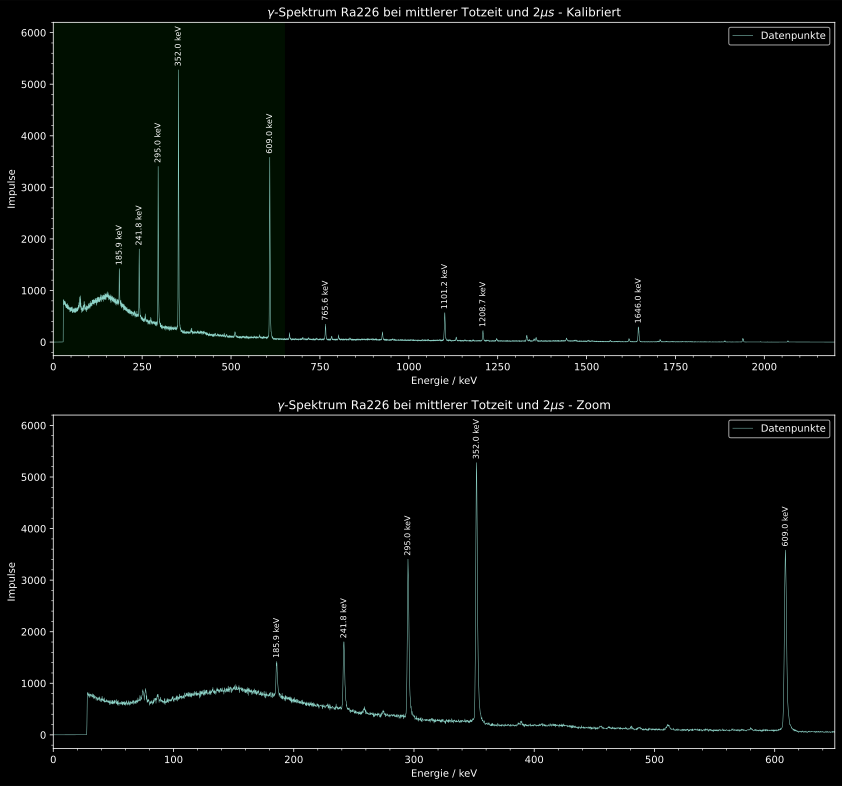

In [12]:
xarr = channels_calib(m2us_channels, energies[3:], m2us["Kanal"], verbose=True)
yarr = m2us["Impulse"].tolist()

fig, ax = plt.subplots(2, 1, figsize=(30*cm, 50*(9/16)*cm))
peaks, _ = find_peaks(yarr, prominence=(180, None), wlen=80)
xpeaks = [xarr[peak] for peak in peaks]
ypeaks= [yarr[peak] for peak in peaks]
for i, axis in enumerate(ax):
	axis.plot(xarr, yarr, '-', linewidth=.5, label="Datenpunkte")
	axis.set_xlabel("Energie / keV")
	axis.set_ylabel("Impulse")
	axis.set_xlim(0, max(xarr)-i*(max(xarr)-650))
	axis.set_ylim(top=6200)
	for xpeak, ypeak in zip(xpeaks[3:], ypeaks[3:]):
		if xpeak < axis.get_xlim()[1]:
			axis.annotate("{} keV".format(round(xpeak,1)), (xpeak, ypeak), (xpeak, ypeak+100), horizontalalignment='center', rotation=90, fontsize=8)
	axis.yaxis.set_minor_locator(MultipleLocator(200))
	axis.legend()
ax[0].fill_between((0, 650/max(xarr)), 0, 1, transform=ax[0].transAxes, color='#000f00')
ax[0].set_title("$\gamma$-Spektrum Ra226 bei mittlerer Totzeit und 2$\\mu s$ - Kalibriert")
ax[0].xaxis.set_minor_locator(MultipleLocator(50))
ax[1].set_title("$\gamma$-Spektrum Ra226 bei mittlerer Totzeit und 2$\\mu s$ - Zoom")
ax[1].xaxis.set_minor_locator(MultipleLocator(20))
plt.tight_layout()